Thoughts:

I had a theory: The model is incentivised to create a flat plane to minimize f(t,x). This way u, u_t, u_x, and u_xx are all close to 0. Additionally, since boundary points at x = = -1, 1 all have the same value (0), a flat plane wouldn't hurt either. It is the easiest way. This theory worked. Until I made all the data points the ones at t = 0 and completely took away the MSE_f loss component. Still, a flat plane appeared. Still, the derivatives died. Less than before. But given that the ONLY job of the entire network at this point was to approximate -sin(x*\pi), it is but a bit concerning that it is STILL unable to do that.

Import statements

In [35]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
import pyDOE2
from torch.autograd.functional import jacobian, hessian


Variables

In [36]:
x_bounds = [-1, 1]
t_bounds = [0, 1]
num_data_points = 200
num_collocation_points = 10000
proportion_t_0 = 0.5 #the proportion of the data points which will exist at various points x along the boundary t = 0. The rest will be split between the boundaries x = -1 and x = 1 for all t

Generating Data

In [37]:
num_points_t_0 = (int) (num_data_points * proportion_t_0)
num_points_x_1 = (num_data_points - num_points_t_0)//2 # // is integer division
num_points_x_neg_1 = num_data_points - num_points_t_0 - num_points_x_1

#create num_data_points random data points on the boundaries of the PDE
t_0_points = np.array( list( zip(np.zeros(num_points_t_0), 2 * np.random.rand(num_points_t_0) - 1 ) ) )
x_1_points = np.array( list( zip(np.random.rand(num_points_x_1), np.full(num_points_x_1, 1)) ) ) #np.full() takes paramters shape, value. Shape can be a tuple for multidimensional arrays filled with value.
x_neg_1_points = np.array( list( zip(np.random.rand(num_points_x_neg_1), np.full(num_points_x_neg_1, -1)) ) )
x_points = np.concatenate(( x_1_points, x_neg_1_points ))

#Generating labels with the data
dtype = [('points', float, 2), ('label', float)] #need custom dtype because otherwise numpy doesn't like these combined arrays

t_0_labels = -np.sin(np.pi * t_0_points[:,1] )
t_0_combined = np.array(list( zip(t_0_points, t_0_labels) ), dtype=dtype)

x_labels = np.zeros(num_points_x_1 + num_points_x_neg_1)
x_combined = np.array(list( zip(x_points, x_labels) ), dtype=dtype)

combined_labels_data = np.concatenate( (t_0_combined, x_combined) )

np.random.shuffle(combined_labels_data)

data_points, labels = map(np.array, map(list, zip(*combined_labels_data)) )
data_points = torch.tensor(data_points.astype(np.float32), requires_grad=True)
labels = torch.tensor(labels.astype(np.float32), requires_grad=True)


Data Validation Code

In [38]:
'''# Test 1: Ensure all data points lie on the correct boundaries
def test_boundaries(data_points):
    t_values = data_points[:, 0]
    x_values = data_points[:, 1]
    assert np.all((t_values == 0) | (x_values == 1) | (x_values == -1)), "Some points do not lie on the correct boundaries."

test_boundaries(data_points)
print("Test 1 passed!")

# Test 2: For t=0, label should be -sin(pi * x)
def test_labels_t_0(data_points, labels):
    mask_t_0 = data_points[:, 0] == 0
    expected_labels = -np.sin(np.pi * data_points[mask_t_0, 1])
    assert np.allclose(labels[mask_t_0], expected_labels), "Labels for t=0 do not match -sin(pi * x)."

test_labels_t_0(data_points, labels)
print("Test 2 passed!")

# Test 3: For x=-1 or x=1, label should be 0
def test_labels_x_boundaries(data_points, labels):
    mask_x_boundaries = (data_points[:, 1] == 1) | (data_points[:, 1] == -1)
    assert np.all(labels[mask_x_boundaries] == 0), "Labels for x=-1 or x=1 are not zero."

test_labels_x_boundaries(data_points, labels)
print("Test 3 passed!")
'''

'# Test 1: Ensure all data points lie on the correct boundaries\ndef test_boundaries(data_points):\n    t_values = data_points[:, 0]\n    x_values = data_points[:, 1]\n    assert np.all((t_values == 0) | (x_values == 1) | (x_values == -1)), "Some points do not lie on the correct boundaries."\n\ntest_boundaries(data_points)\nprint("Test 1 passed!")\n\n# Test 2: For t=0, label should be -sin(pi * x)\ndef test_labels_t_0(data_points, labels):\n    mask_t_0 = data_points[:, 0] == 0\n    expected_labels = -np.sin(np.pi * data_points[mask_t_0, 1])\n    assert np.allclose(labels[mask_t_0], expected_labels), "Labels for t=0 do not match -sin(pi * x)."\n\ntest_labels_t_0(data_points, labels)\nprint("Test 2 passed!")\n\n# Test 3: For x=-1 or x=1, label should be 0\ndef test_labels_x_boundaries(data_points, labels):\n    mask_x_boundaries = (data_points[:, 1] == 1) | (data_points[:, 1] == -1)\n    assert np.all(labels[mask_x_boundaries] == 0), "Labels for x=-1 or x=1 are not zero."\n\ntest_labels

Preparing the Dataset and Dataloader

In [39]:
'''class PINN_DataSet(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

trainset = PINN_DataSet(data_points.astype(np.float32), labels.astype(np.float32)) #convert to float32, or else later the resulting torch tensors will be of torch.float64 type, which is not compatible with the neural network

#batch_size = num_data_points #no mini-batches
#batch_size = 50

num_workers = 0

trainloader = DataLoader(
    trainset,
    #batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)
'''


'class PINN_DataSet(Dataset):\n    def __init__(self, data, labels):\n        self.data = data\n        self.labels = labels\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        return self.data[idx], self.labels[idx]\n\ntrainset = PINN_DataSet(data_points.astype(np.float32), labels.astype(np.float32)) #convert to float32, or else later the resulting torch tensors will be of torch.float64 type, which is not compatible with the neural network\n\n#batch_size = num_data_points #no mini-batches\n#batch_size = 50\n\nnum_workers = 0\n\ntrainloader = DataLoader(\n    trainset,\n    #batch_size = batch_size,\n    shuffle = True,\n    num_workers = num_workers\n)\n'

Collocation Points

In [40]:
def lhs_samples(n): #generate n collocation points via Latin Hypercube Sampling. Each point is a (t,x)
    lhs_array = pyDOE2.lhs(2, samples=n) #Two dimensions. Values from 0 to 1
    lhs_array[:,1] = 2*lhs_array[:,1] - 1 #convert range of x values to -1 to 1
    return lhs_array

collocation_points = lhs_samples(num_collocation_points)

Defining the Neural Network

In [41]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( #9 layers of 20 neurons each
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
            #nn.Tanh()

        )

    def forward(self, x):
        return self.net(x)



Loss Function

In [42]:
def MSE_f(collocation_points, neural_network, device): #I need to better understand how exactly autograd handles vectorization. I think I just waste 6 hours on a wild goose chase due to a misconception about that very fact...

    np.random.shuffle(collocation_points)
    #collocation_points = collocation_points[80:]

    collocation_inputs = torch.tensor(collocation_points.astype(np.float32), requires_grad=True).to(device)
    
    u = neural_network(collocation_inputs)
    results, = torch.autograd.grad(u, collocation_inputs, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)
    u_t = results[:,0]
    u_x = results[:,1]
    snd_result, = torch.autograd.grad(u_x, collocation_inputs, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)
    u_xx = snd_result[:,1]
    #print(f"u: {u[:5]}")
    #print(f"u_t: {u_t[:5]}")
    #print(f"u_x: {u_x[:5]}")
    #print(f"u_xx: {u_xx[:5]}")
    final_result = torch.mean((u_t + u*u_x - (0.01/torch.pi)*u_xx)**2)
    return final_result
    
def MSE_u(output, label):
    return torch.mean((output - label)**2)


def criterion(output, label, collocation_points, neural_network, device):
    #mse_u = nn.MSELoss()(output, label).squeeze()
    mse_u = MSE_u(output, label).squeeze()
    mse_f = MSE_f(collocation_points, neural_network, device).squeeze()
    return  mse_u + mse_f, mse_u.item(), mse_f.item()
    #return 10*(mse_u + mse_f), mse_u.item(), mse_f.item()

Model Training

In [43]:
pinn = PINN()
optimizer = torch.optim.LBFGS(pinn.parameters(), #PARAMETERS CREDIT TO https://github.com/teeratornk/PINNs-2/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb
                              lr=2,
                              max_iter=50000, 
                                max_eval=50000, 
                                history_size=50,
                                tolerance_grad=1e-5, 
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn="strong_wolfe"
                              )

num_epochs = 5

#use the GPU to train if possible, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
pinn.to(device)

try:
    for epoch in range(num_epochs):

        print(f"EPOCH {epoch + 1} out of {num_epochs}")
        train_running_loss = 0

        input = data_points.to(device)
        label = labels.to(device)


        def closure():
            optimizer.zero_grad() #reset the gradient so that the previous iteration does not affect the current one
            output = pinn(input) #run the batch through the current model
            loss, mse_u, mse_f = criterion(output, label, collocation_points, pinn, device) #calculate the loss
            loss.backward() #Using backpropagation, calculate the gradients
            print(f"Avg MSE Loss Per Boundary Data Point: {mse_u}")
            print(f"Avg f(t,x)^2 Per Collocation Point: {mse_f}")
            return loss

        optimizer.step(closure) #Using the gradients, adjust the parameters    

except KeyboardInterrupt:
    print("Training interrupted by user.")  

print("TRAINING COMPLETE!")

MSE_f(collocation_points,pinn,device)

Using device: CPU
EPOCH 1 out of 5


Avg MSE Loss Per Boundary Data Point: 0.32698917388916016
Avg f(t,x)^2 Per Collocation Point: 3.452488428479228e-08
Avg MSE Loss Per Boundary Data Point: 0.28979605436325073
Avg f(t,x)^2 Per Collocation Point: 2.7417948800234626e-08
Avg MSE Loss Per Boundary Data Point: 0.2898060083389282
Avg f(t,x)^2 Per Collocation Point: 1.8275825297564552e-08
Avg MSE Loss Per Boundary Data Point: 0.288827508687973
Avg f(t,x)^2 Per Collocation Point: 2.204487792312193e-08
EPOCH 2 out of 5
Avg MSE Loss Per Boundary Data Point: 0.288827508687973
Avg f(t,x)^2 Per Collocation Point: 2.204487969947877e-08
EPOCH 3 out of 5
Avg MSE Loss Per Boundary Data Point: 0.288827508687973
Avg f(t,x)^2 Per Collocation Point: 2.204487792312193e-08
EPOCH 4 out of 5
Avg MSE Loss Per Boundary Data Point: 0.288827508687973
Avg f(t,x)^2 Per Collocation Point: 2.204487792312193e-08
EPOCH 5 out of 5
Avg MSE Loss Per Boundary Data Point: 0.288827508687973
Avg f(t,x)^2 Per Collocation Point: 2.204487792312193e-08
TRAINING COMP

tensor(2.2045e-08, grad_fn=<MeanBackward0>)

Saving the Code

In [44]:
base_path = "./"
base_name = "pinn_model"
extension = ".pth"

counter = 0
model_save_path = os.path.join(base_path, base_name + extension)

while os.path.exists(model_save_path):
    counter += 1
    model_save_path = os.path.join(base_path, f"{base_name}_{counter}{extension}")

torch.save(pinn.state_dict(), model_save_path)

print("Model saved!")

Model saved!


Visual Plot

[[-0.02480085]
 [-0.02731654]
 [-0.02619524]
 ...
 [-0.02690051]
 [-0.02761284]
 [-0.02552198]]


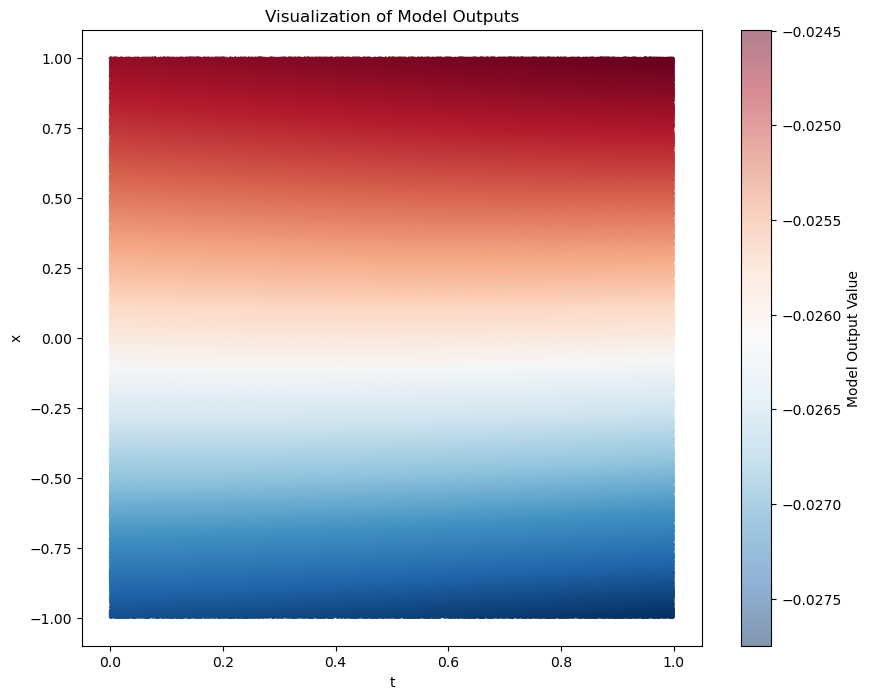

In [45]:
#Generate Random Points
num_points = 1000000
t_values = np.random.rand(num_points)
x_values = np.random.uniform(-1, 1, num_points)
points = np.vstack((t_values, x_values)).T
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)



#Feed the Points through the Model
with torch.no_grad():
    model_outputs = pinn(points_tensor).cpu().numpy()
    #print(model_outputs)

print(model_outputs[20:])

# Normalize the model outputs to be between 0 and 1 for color mapping
normalized_outputs = (model_outputs - (-1)) / (1 - (-1))


#Plotting
plt.figure(figsize=(10, 8))
plt.scatter(t_values, x_values, c=model_outputs.squeeze(), cmap='RdBu_r', s=1, alpha=0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label='Model Output Value')
plt.title("Visualization of Model Outputs")
plt.show()


Plotting x values again u(x)

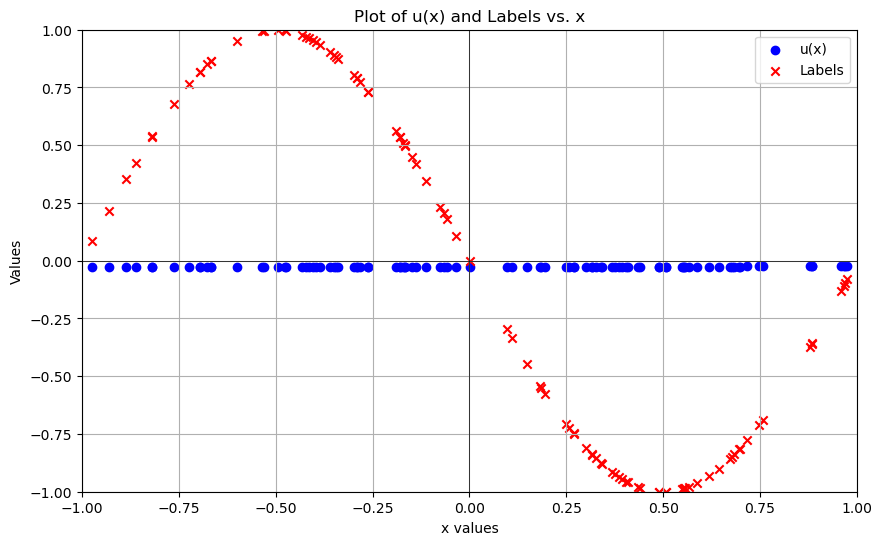

In [55]:
def plot_tensors(x, u, labels):
    # Convert tensors to numpy arrays
    x_np = x
    u_np = u

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_np, u_np, color='blue', marker='o', label='u(x)')
    
    if labels is not None:
        labels_np = labels
        plt.scatter(x_np, labels_np, color='red', marker='x', label='Labels')
    
    plt.title('Plot of u(x) and Labels vs. x')
    plt.xlabel('x values')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
x = t_0_points[:,1]
u = pinn(torch.Tensor(t_0_points.astype(np.float32))).detach().numpy()

plot_tensors(x, u, t_0_labels)